# Network Processing
---

## Run this code block by block to convert a road network(s) in ESRI Shapefile or GeoJSON format into a routable and conflated network graph to use in BikewaySim.

Note that three networks were used in this project. While code to obtain OSM GeoJSONs has been included with osm_processing notebook, the ABM and HERE networks need to be sourced from the Atlanta Regional Commission and HERE respectively. You can run most of this code with only OSM data, but you'll need to skip the conflation section.

## Import/install the following packages:


In [11]:
import os
from pathlib import Path
import time
import geopandas as gpd
import pickle

## Import Network Filter Module:

In [12]:
from network_filter import *

## Set Directory:
### Modify this directory to where you stored your network shapefiles.

In [14]:
user_directory = os.fspath(Path.home()) #get home directory and convert to path string
file_directory = r"/Documents/BikewaySimData" #directory of bikewaysim outputs
os.chdir(user_directory+file_directory)

### Choose desired projected coordinate reference system (CRS) to work with
This needs to be set to check that all the data is in the same CRS. The one used for this study was EPSG 2240 (https://spatialreference.org/ref/epsg/nad83-georgia-west-ftus/)

In [15]:
desired_crs = "EPSG:2240"

## Choose study area (needs to be spatial file with single polygon):
Specify what area you want to mask the network data by. Only network links that are partially or fully within the study area will be imported. Note: Network links are NOT clipped (because this creates new nodes), any links that are at least partially within the study area are brought in.

The area of the bikewaysim study area is 12.4 square miles.


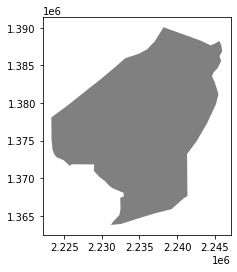

In [16]:
studyareafp = r'base_shapefiles/bikewaysim_study_area/bikewaysim_study_area.shp'
studyarea_name = 'bikewaysim'
#city_of_atlantafp = r'base_shapefiles/coa/Atlanta_City_Limits.shp'
#atlanta_regional_commissionfp = r'base_shapefiles/arc/arc_bounds.shp'

#add new study areas if desired
studyarea = import_study_area(studyareafp, studyarea_name, desired_crs)

## Network Mapper
This is how network node ID's will be identified and coded
- the first number in the node ID represents its origin network
- all numbers after that are the original network ID. we did this to make sure that there are no duplicate network ids and to make it easy to retreive the original network id.

In [17]:
network_mapper = {
    "abm": "1",
    "here": "2",
    "osm": "3",
    "original": "0",
    "generated": "1"
}

## Network Data Filepaths:

In [18]:
abmfp = r'base_shapefiles/arc/ABM2020-TIP20-2020-150kShapefiles-outputs.gdb'
abmnodesfp = r'base_shapefiles/arc/ABM2020-TIP20-2020-150kShapefiles-outputs.gdb'
herefp = r'base_shapefiles/here/Streets.shp'
osmfp = r'base_shapefiles/osm/osm_network_bikewaysim.gpkg'
osmnodesfp = r'base_shapefiles/osm/osm_network_bikewaysim.gpkg'

In [19]:
#Use to list layers if needed for ESRI geodatabase files or Geopackages
import fiona
fiona.listlayers('base_shapefiles/arc/ABM2020-TIP20-2020-150kShapefiles-outputs.gdb')

DriverError: base_shapefiles/arc/ABM2020-TIP20-2020-150kShapefiles-outputs.gdb: No such file or directory

## Set Network Import Settings
#### Create a dictionary for use in filter networks function. 
#### For new networks follow this format:
```python
network = {
       "studyarea": studyarea, #geodataframe of the study area
       "studyarea_name": studyarea_name, #name for the study area
       "networkfp": networkfp, #filepath for the network, specified earlier
       "network_name": 'abm', #name for the network being evaluated
       "network_mapper": network_mapper, #leave this, edit in the block above
       "A": "A", #column with the starting node id; replace with None if there isn't a column
       "B": "B", #column with the ending node id; replace with None if there isn't a column
       "layer": 0 #if network has layers, then specify which layer to look at; if no layers then leave as 0 
       }
```

In [20]:
#abm inputs
abm = {
       "studyarea": studyarea,
       "studyarea_name": studyarea_name,
       "networkfp": abmfp,
       "network_name": 'abm',
       "network_mapper": network_mapper,
       "layer": "DAILY_Link",
       "desired_crs": "epsg:2240",
       "nodesfp": abmnodesfp,
       "nodes_layer":"DAILY_Node",
       "node_id": 'N',
       "A": "A",
       "B": "B"
       }

#here inputs
here = {
       "studyarea": studyarea,
       "studyarea_name": studyarea_name,
       "networkfp": herefp,
       "network_name": 'here',
       "network_mapper": network_mapper,
       "layer":None,
       "desired_crs":"epsg:2240",
       "nodesfp":None,
       "nodes_layer":None,
       "node_id": None,
       "A": "REF_IN_ID",
       "B": "NREF_IN_ID"
       }

osm = {
      "studyarea": studyarea,
       "studyarea_name": studyarea_name,
       "networkfp": osmfp,
       "network_name": 'osm',
       "network_mapper": network_mapper,
       "layer":"links",
       "desired_crs":"epsg:2240",
       "nodesfp":osmnodesfp,
       "nodes_layer":"nodes",
       "node_id": "osmid",
       "A": "A",
       "B": "B"
       }

## Run Network Filter Module to Create Initial Subnetworks
From the network_filter.py file run the filter networks function. This will first import the spatial data and then filter the data into a base, road, bike, or serivce link. 
**Note: If this is the a new network that is not OSM, HERE, or ABM then specify a new filter method by going into the network_filter.py file.** Otherwise, none of the links will be filtered into road/bike/service links. **Also note: all spatial files are being projected to EPSG 2240 right now.** Need to modify later.


## Filter ABM

In [10]:
#filter_networks(**abm)

## Filter HERE

In [11]:
#filter_networks(**here)

## Filter OSM

In [21]:
filter_networks(**osm)

/Users/tannerpassmore/Documents/GitHub/BikewaySimDev/network_filter.py:77: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  links = gpd.read_file(networkfp, mask = studyarea, layer = layer).explode().droplevel(level=1).to_crs(desired_crs)


Cleaning measures applied for osm...
osm road filter applied...
osm bike filter applied...
osm service filter applied...
osm imported... took 0.24 minutes


## Summurize filtered networks
#### Prints out:
- Number of nodes
- Number of links
- Total length of all links
- Average link length

#### Exports:
- CSV file with all the network statistics.

In [13]:
from network_summary_stats import * 

#network names to look for, will search your directory for network name
networks = ["abm","here","osm"]
studyarea_name = "bikewaysim"

#summurize networks and export summary as "network_summary.csv in the working directory
sum_all_networks(networks, studyarea_name)

  network name link_type num_links num_nodes  tot_link_length  avg_link_length
0          abm      base      1661      1519             88.0            278.3
1          abm      road      1661      1519             88.0            278.3
2         here      base     12080      9364            386.0            168.8
3         here      road      5575      4771            225.0            213.4
4         here      bike      2025      1791             47.0            122.8
5         here   service      4480      4813            114.0            134.1
6          osm      base     17641     14933            430.0            128.8
7          osm      road      6838      6013            218.0            168.1
8          osm      bike      3296      3145             63.0            100.4
9          osm   service      7514      8559            150.0            105.4


## Conflation Process
In this step, the networks are conflated to each other by utilizing functions in the network_conflation.py module

I like to remove all of the columns that aren't related to node_id or geometry for this step. To make sure we preserve link information I also make a A_B column


There are three main functions in conflation module:
- The first just matches nearest points
- The second will find the nearest spot on a link from a different network node and create a new node
- The last is a function that deals with removing links/nodes that have already been considered, so they aren't duplicated


#only select columns that correspond to A, B, and geo

#create an A_B column

#determine what you want the base network to be, and which order you want to conflate in
#for this project, ABM was the base with HERE followed by OSM as the joining ones.




#do this step outside of the function

#Filter joining network
This should make it so that the only joining nodes that the base nodes can join to represent real intersections
<code>joining_nodes = joining_nodes[joining_nodes[f'{joining_name}_num_links'] != 2 ].reset_index(drop=True)<code>


In [14]:
from conflation_tools import *

### Links and Nodes to Conflate

In [15]:
base_name = "abm"
join_name = "here"

#road layers
base_links = gpd.read_file(r"processed_shapefiles/abm/abm_bikewaysim_road_links.geojson")
base_nodes = gpd.read_file(r"processed_shapefiles/abm/abm_bikewaysim_road_nodes.geojson")
join_links = gpd.read_file(r"processed_shapefiles/here/here_bikewaysim_road_links.geojson")
join_nodes = gpd.read_file(r"processed_shapefiles/here/here_bikewaysim_road_nodes.geojson")

### Cleaning to get rid of excess columns

In [16]:
base_links, base_nodes = cleaning_process(base_links,base_nodes,base_name)
join_links, join_nodes = cleaning_process(join_links,join_nodes,join_name)

### Node Matching
This function matches nodes within a set tolerence (in feet) that are likely to be the same nodes. This function is intended for matching road intersections or road termini since these are likely to be in both networks. This function can be applied with an iteratively increasing tolerance if you're not sure what's a good tolerance. At some point, the number of matched nodes will not increase by much.

The match results will get printed out.

#### NOTE: This function handles duplicate matches (i.e. when two or more nodes share a nearest node in the other network) by selecting the one with the shorter match distance. The duplicates won't be rematched unless you run the matching process again.

#### When looping match function, feed outputs from previous

### Function Inputs
- base_nodes, base_name, join_nodes, join_name # self explanatory
- tolerance_ft: the match tolerance in units of feet
- prev_matched_nodes: geodataframe of the list of currently matched nodes, set to none for first run
- remove_duplicates: if set to 'True' (default), then remove duplicate matches. If set to false, duplicate matches will be returned in the matched_nodes gdf.
- export_error_lines: if set to 'False', a geojson of linestrings visualizing the matches will be written.
- export_unmatched: if you want a geojson of the nodes that didn't match in each network set this to true (False by default).

### Function Outputs
- matched_nodes: a df of matched nodes, just the node ids.
- unmatched_base_nodes: a gdf of the base nodes that weren't matched.
- unmatched_join_nodes: a gdf of the join nodes that weren't matched.

In [17]:
#first match the nodes, can repeat this by adding in previously matched_nodes
tolerance_ft = 25
matched_nodes, unmatched_base_nodes, unmatched_join_nodes = match_nodes(base_nodes,
                                                                        base_name,
                                                                        join_nodes,
                                                                        join_name,
                                                                        tolerance_ft,
                                                                        prev_matched_nodes=None
                                                                       )

1422 initial matches
There were 12 duplicates, now there are 1416 matches.
There are 103 abm nodes and 3355 here nodes remaining
1416 node pairs have been matched so far.


In [18]:
#base_nodes = base_nodes[-base_nodes[f'{base_name}_ID'].isin(matched_nodes[f'{base_name}_ID'])]
#join_nodes = join_nodes[-join_nodes[f'{join_name}_ID'].isin(matched_nodes[f'{join_name}_ID'])]
#matched_nodes is not None

In [19]:
#second iteration example with same tolerance
matched_nodes, unmatched_base_nodes, unmatched_join_nodes = match_nodes(base_nodes,
                                                                        base_name,
                                                                        join_nodes,
                                                                        join_name,
                                                                        tolerance_ft,
                                                                        prev_matched_nodes=matched_nodes
                                                                       )

#third iteration example wiht larger tolerance
tolerance_ft = 30
matched_nodes, unmatched_base_nodes, unmatched_join_nodes = match_nodes(base_nodes,
                                                                        base_name,
                                                                        join_nodes,
                                                                        join_name,
                                                                        tolerance_ft,
                                                                        prev_matched_nodes=matched_nodes
                                                                       )

#join the matched nodes to the base nodes once done with matching
matched_nodes_final = pd.merge(base_nodes, matched_nodes, on = f'{base_name}_ID', how = "left")

0 initial matches
There were 0 duplicates, now there are 0 matches.
There are 103 abm nodes and 3355 here nodes remaining
1416 node pairs have been matched so far.
17 initial matches
There were 0 duplicates, now there are 17 matches.
There are 86 abm nodes and 3338 here nodes remaining
1433 node pairs have been matched so far.


### Link Splitting and Add New Links and Nodes
This function will split links in the base network if there's a node in the join network that is within a certain tolerance. This creates new nodes and links on the base network. The original base links are then replaced with these new links/nodes.

#### NOTE: This may create way more links/nodes than neccessary.

It may be wise to consider limiting the kind of join nodes that can split a base link. For instance, OSM has lots of additional links and nodes because there are sidewalks. The nodes used to access these sidewalks will split the base link, which creates additional link where there otherwise would be none. These added links/nodes can slow down computational time for shortest path calculation. However, it could be adventageous in the attribute transfer process.

#### Looping
This function can be looped if unsure what tolerance or nodes to use. 

### Function Inputs
- unmatched_join_nodes: These are the join nodes that weren't matched to base nodes in the previous step
- join_name, base_links, base_name: self-explanatory
- tolerance_ft: the matching tolerance in feet
- export: set to 'True' to get a GeoJSON of new links and nodes that were created

### Function Outputs
- split_lines: a gdf of just the new base links
- split_nodes: a gdf of jsut the new base nodes
- unmathced_join_nodes: a gdf of the join nodes that didn't match

In [20]:
unmatched_join_nodes.head()

,here_ID,here_point_geo
0,201000979665,POINT (2227264.443 1380228.027)
1,201000979666,POINT (2227334.325 1380231.511)
2,201000979668,POINT (2227392.047 1380231.383)
4,201008606020,POINT (2236530.936 1371032.021)
5,201008606022,POINT (2236628.236 1371060.944)


In [21]:
#create new node and lines from the base links by splitting lines can repeat after the add_new_links_nodes function
tolerance_ft = 25
split_lines, split_nodes, unmatched_join_nodes = split_lines_create_points(unmatched_join_nodes,
                                                                           join_name,
                                                                           base_links,
                                                                           base_name,
                                                                           tolerance_ft,
                                                                           export = False)
split_lines.head()

There are 1352 here points matching to 674 abm links
There are 1986 here nodes remaining
There were 1982 new lines created.


C:\Users\tpassmore6\Documents\GitHub\BikewaySimDev\conflation_tools.py:217: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  df_split = df_split.explode().reset_index(drop=True)


,abm_A_B,abm_line_geo
0,1051440_10233760,"LINESTRING (2232771.147 1365480.263, 2232767.7..."
1,1051440_10233760,"LINESTRING (2232767.750 1365283.029, 2232767.7..."
2,1051440_10233760,"LINESTRING (2232761.131 1365039.274, 2232761.0..."
3,1051792_1051798,"LINESTRING (2228604.215 1373941.731, 2228586.2..."
4,1051792_1051798,"LINESTRING (2228585.852 1374072.203, 2228571.3..."


In [22]:
#add new links and nodes to the base links and nodes created from split_lines_create_points function
new_links, new_nodes = add_new_links_nodes(base_links, matched_nodes_final, split_lines, split_nodes, base_name)
new_links.head()

,abm_A_B,abm_line_geo
1,1010848_10340018,"LINESTRING (2233265.865 1384662.528, 2233329.3..."
3,1010854_1010856,"LINESTRING (2231248.476 1375719.070, 2231166.4..."
6,1013524_1053435,"LINESTRING (2239431.313 1375903.192, 2239373.5..."
7,1013524_10299911,"LINESTRING (2239431.313 1375903.192, 2239452.5..."
9,1013525_1053438,"LINESTRING (2239619.442 1375764.578, 2239568.0..."


### Attribute Transfer
In the previous steps, we found geometric commonalties between the networks. In this step, we want to transfer attribute information from the join network into the base network. Link attributes are based on a link's reference ids, but the current set of links may not have reference ids that correspond to a join network link.

To address this, we buffer the base links and intersect them with the join links. We then measure the length of the resulting linestrings. The attribute information from the join links that have the maximum length (i.e. the maximum amount of overlap with the base link) is tranferred. This ensures that each base link is associated with only one join link's attributes.

### NOTE: The buffer here needs to be smaller
If it's larger, then a longer join node could be selected as the join link with most overlap.

This process will likely change in the future. A different approach might be to look at all the base links with at least one join node in the reference id column, and then look up all the links in the join network associated with that node (there should only be a few). Using other reference node that doesn't have a join node id, the nearest node in that lookup table could be found.

In [23]:
#match attribute information with greatest overlap from joining links
buffer_ft = 30
new_base_links_w_attr = add_attributes(new_links, base_name, join_links, join_name, buffer_ft)
new_base_links_w_attr.head()

,abm_A_B,abm_line_geo,here_A_B
0,1010848_10340018,"LINESTRING (2233265.865 1384662.528, 2233329.3...",201063859187_2017289087
1,1010854_1010856,"LINESTRING (2231248.476 1375719.070, 2231166.4...",2017289109_2017289100
2,1013524_1053435,"LINESTRING (2239431.313 1375903.192, 2239373.5...",2044584013_2030636889
3,1013524_10299911,"LINESTRING (2239431.313 1375903.192, 2239452.5...",2030636889_2044584017
4,1013525_1053438,"LINESTRING (2239619.442 1375764.578, 2239568.0...",201181585260_2044584017


### Add rest of features
Now that we've settled the geometric and attribute commonalities between the base and join networks, we can add in the join network features that aren't represented in the base network. This is done using a buffer. If a join link is covered at least 95% by a base link, then it is left out.

In [24]:
#add unrepresented features from joining by looking at the attributes added in previous step for links and the list of matched nodes
added_base_links, added_base_nodes = add_rest_of_features(new_base_links_w_attr,new_nodes,base_name,join_links,join_nodes,join_name)

#create new abmhere column with id and geo
final_links, final_nodes = fin_subnetwork(added_base_links,added_base_nodes,base_name,join_name)

final_links.to_file(rf'processed_shapefiles/conflation/{base_name+join_name}_links.geojson')
final_nodes.to_file(rf'processed_shapefiles/conflation/{base_name+join_name}_nodes.geojson')

C:\Users\tpassmore6\Anaconda3\envs\geo-env\lib\site-packages\pandas\core\dtypes\cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
C:\Users\tpassmore6\Anaconda3\envs\geo-env\lib\site-packages\pandas\core\dtypes\cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


### Save as pickle, this is more of a progress save

In [25]:
#pickle.dump(added_base_links, open("processed_shapefiles/conflation/inter/abm_here_road.p","wb"))
#pickle.dump(added_base_nodes, open("processed_shapefiles/conflation/inter/abm_here_road.p","wb"))

### Repeat for OSM
Now that we've resovled ABM and HERE, we can add the second join network.

In [26]:
base_name = "abmhere"
base_links = final_links
base_nodes = final_nodes

join_name = "osm"
join_links = gpd.read_file(r"processed_shapefiles/osm/osm_bikewaysim_road_links.geojson")
join_nodes = gpd.read_file(r"processed_shapefiles/osm/osm_bikewaysim_road_nodes.geojson")

In [27]:
#clean join links (no need to clean base links)
join_links, join_nodes = cleaning_process(join_links,join_nodes,join_name)

In [28]:
#first match the nodes, can repeat this by adding in previously matched_nodes
tolerance_ft = 25
matched_nodes, unmatched_base_nodes, unmatched_join_nodes = match_nodes(base_nodes, base_name, join_nodes, join_name, tolerance_ft, prev_matched_nodes=None)

#join the matched nodes to the base nodes once done with matching
matched_nodes_final = pd.merge(base_nodes, matched_nodes, on = f'{base_name}_ID', how = "left")

3008 initial matches
There were 206 duplicates, now there are 2928 matches.
There are 1929 abmhere nodes and 3112 osm nodes remaining
2928 node pairs have been matched so far.


In [29]:
#create new node and lines from the base links by splitting lines can repeat after the add_new_links_nodes function
tolerance_ft = 25
split_lines, split_nodes, unmatched_join_nodes = split_lines_create_points(unmatched_join_nodes,
                                                                           join_name,
                                                                           base_links,
                                                                           base_name,
                                                                           tolerance_ft,
                                                                           export = False)
split_lines.head()
split_lines.to_file('processed_shapefiles/conflation/split_lines.geojson')

There are 2835 osm points matching to 1695 abmhere links
There are 277 osm nodes remaining


C:\Users\tpassmore6\Documents\GitHub\BikewaySimDev\conflation_tools.py:217: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  df_split = df_split.explode().reset_index(drop=True)


There were 4014 new lines created.


In [30]:
#add new links and nodes to the base links and nodes created from split_lines_create_points function
new_links, new_nodes = add_new_links_nodes(base_links, matched_nodes_final, split_lines, split_nodes, base_name)
new_links.head()

,abm_A_B,abmhere_line_geo,here_A_B,abmhere_A_B
0,1010848_10340018,"LINESTRING (2233265.865 1384662.528, 2233329.3...",201063859187_2017289087,1010848_10340018
1,1010854_1010856,"LINESTRING (2231248.476 1375719.070, 2231166.4...",2017289109_2017289100,1010854_1010856
3,1013524_10299911,"LINESTRING (2239431.313 1375903.192, 2239452.5...",2030636889_2044584017,1013524_10299911
8,1048680_10300690,"LINESTRING (2223786.066 1373104.741, 2223813.3...",20979792205_2044571513,1048680_10300690
10,1048684_1048699,"LINESTRING (2223553.208 1373585.593, 2223610.6...",2044571548_2044571524,1048684_1048699


In [31]:
#match attribute information with greatest overlap from joining links
buffer_ft = 30
new_base_links_w_attr = add_attributes(new_links, base_name, join_links, join_name, buffer_ft)
new_base_links_w_attr.head()

,abm_A_B,abmhere_line_geo,here_A_B,abmhere_A_B,osm_A_B
0,1010848_10340018,"LINESTRING (2233265.865 1384662.528, 2233329.3...",201063859187_2017289087,1010848_10340018,304616440440_306003270865
1,1010854_1010856,"LINESTRING (2231248.476 1375719.070, 2231166.4...",2017289109_2017289100,1010854_1010856,302508783158_305416547103
2,1013524_10299911,"LINESTRING (2239431.313 1375903.192, 2239452.5...",2030636889_2044584017,1013524_10299911,3069151116_308750722897
3,1048680_10300690,"LINESTRING (2223786.066 1373104.741, 2223813.3...",20979792205_2044571513,1048680_10300690,3069175030_3069576878
4,1048684_1048699,"LINESTRING (2223553.208 1373585.593, 2223610.6...",2044571548_2044571524,1048684_1048699,3069116075_3069516241


In [32]:
#add unrepresented features from joining by looking at the attributes added in previous step for links and the list of matched nodes
added_base_links, added_base_nodes = add_rest_of_features(new_base_links_w_attr,new_nodes,base_name,join_links,join_nodes,join_name)

#create new abmhere column with id and geo
final_links, final_nodes = fin_subnetwork(added_base_links,added_base_nodes,base_name,join_name)

C:\Users\tpassmore6\Anaconda3\envs\geo-env\lib\site-packages\pandas\core\dtypes\cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
C:\Users\tpassmore6\Anaconda3\envs\geo-env\lib\site-packages\pandas\core\dtypes\cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


In [33]:
final_links.to_file(rf'processed_shapefiles/conflation/{base_name+join_name}_links.geojson')
final_nodes.to_file(rf'processed_shapefiles/conflation/{base_name+join_name}_nodes.geojson')

# Bike Subnetworks

In [34]:
#bike layers
bike_links = gpd.read_file(r'processed_shapefiles/here/here_bikewaysim_bike_links.geojson')
bike_nodes = gpd.read_file(r'processed_shapefiles/here/here_bikewaysim_bike_nodes.geojson')
bike_name = 'here'

In [35]:
#clean excess columns
bike_links, bike_nodes = cleaning_process(bike_links,bike_nodes,bike_name)

### Merge with other networks

In [36]:
tolerance_ft = 25
merged_links, merged_nodes = merge_diff_networks(added_base_links, added_base_nodes, 'road', bike_links, bike_nodes, 'bike', tolerance_ft)

390 nodes already in the base network
True
here_ID_bike           False
here_point_geo_bike    False
dtype: bool


C:\Users\tpassmore6\Anaconda3\envs\geo-env\lib\site-packages\pandas\core\dtypes\cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
C:\Users\tpassmore6\Anaconda3\envs\geo-env\lib\site-packages\pandas\core\dtypes\cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


### Add reference IDs

In [37]:
# match reference IDs based on all the id in the nodes
refid_base_links = add_reference_ids(merged_links, merged_nodes)

C:\Users\tpassmore6\Anaconda3\envs\geo-env\lib\site-packages\pandas\core\dtypes\cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
C:\Users\tpassmore6\Anaconda3\envs\geo-env\lib\site-packages\pandas\core\dtypes\cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


In [38]:
refid_base_links.head()

,abm_A_B,abmhereosm_line_geo,here_A_B,abmhere_A_B,osm_A_B,abmhereosm_A_B,abm_A,here_A,abmhere_A,osm_A,abmhereosm_A,abm_B,here_B,abmhere_B,osm_B,abmhereosm_B
0,1010848_10340018,"LINESTRING (2233265.865 1384662.528, 2233329.3...",201063859187_2017289087,1010848_10340018,304616440440_306003270865,1010848_10340018,1010848,2017289087,1010848,304616440440,1010848,10340018,201063859187,10340018,NaN,10340018
1,1010854_1010856,"LINESTRING (2231248.476 1375719.070, 2231166.4...",2017289109_2017289100,1010854_1010856,302508783158_305416547103,1010854_1010856,1010854,2017289100,1010854,302508783158,1010854,1010856,2017289109,1010856,NaN,1010856
2,1013524_10299911,"LINESTRING (2239431.313 1375903.192, 2239452.5...",2030636889_2044584017,1013524_10299911,3069151116_308750722897,1013524_10299911,1013524,2030636889,1013524,3069151116,1013524,10299911,NaN,10299911,NaN,10299911
3,1048680_10300690,"LINESTRING (2223786.066 1373104.741, 2223813.3...",20979792205_2044571513,1048680_10300690,3069175030_3069576878,1048680_10300690,1048680,2044571513,1048680,3069175030,1048680,10300690,20979792205,10300690,NaN,10300690
4,1048684_1048699,"LINESTRING (2223553.208 1373585.593, 2223610.6...",2044571548_2044571524,1048684_1048699,3069116075_3069516241,1048684_1048699,1048684,2044571524,1048684,3069116075,1048684,1048699,2044571548,1048699,3069516241,1048699


### Export

In [39]:
refid_base_links.to_file(r'processed_shapefiles\conflation\final_links.geojson', driver = 'GeoJSON')
merged_nodes.to_file(r'processed_shapefiles\conflation\final_nodes.geojson', driver = 'GeoJSON')

## Convert for use in BikewaySim

This last section focusses on making sure that the conflated network is readable by BikewaySim. After this is completed, you can run the Running BikwaySim notebook.

In [40]:
import os
from pathlib import Path
import time
import pandas as pd
import geopandas as gpd
import pickle

#make directory/pathing more intuitive later
file_dir = r"C:\Users\tpassmore6\Documents\BikewaySimData" #directory of bikewaysim network processing code

#change this to where you stored this folder
os.chdir(file_dir)

### Specify filepaths

In [41]:
#filepath for just OSM network
conflated_linksfp
conflated_nodesfp

#filepath for conflated network
#conflated_linksfp = r'processed_shapefiles\conflation\final_links.geojson'
#conflated_nodesfp = r'processed_shapefiles\conflation\final_nodes.geojson'

#filepaths for network attribute data (doesn't have to be a shapefile)
abm_linksfp = r'processed_shapefiles\abm\abm_bikewaysim_base_links.geojson'
here_linksfp = r'processed_shapefiles\here\here_bikewaysim_base_links.geojson'
osm_linksfp = r'base_shapefiles\osm\osm_links_attr.p'

NameError: name 'conflated_linksfp' is not defined

#### Node cleaning and export

In [ ]:
#import conflated nodes
conflated_nodes = gpd.read_file(conflated_nodesfp)

#drop the num links columns
conflated_nodes = conflated_nodes.drop(columns=['abm_num_links','here_num_links'])

#create an N column that takes the abm_id if avaiable followed by the here_id
func = lambda row: row['here_ID'] if row['abm_ID'] == None else row['abm_ID']
conflated_nodes['N'] = conflated_nodes.apply(func,axis=1)

#create UTM coords columns
conflated_nodes['X'] = conflated_nodes.geometry.x
conflated_nodes['Y'] = conflated_nodes.geometry.y

#reproject and find latlon
conflated_nodes = conflated_nodes.to_crs(epsg=4326)
conflated_nodes['lon'] = conflated_nodes.geometry.x
conflated_nodes['lat'] = conflated_nodes.geometry.y

#filter
conflated_nodes = conflated_nodes[['N','X','Y','lon','lat','geometry']]

#export
conflated_nodes.to_file(r'processed_shapefiles\prepared_network\nodes\nodes.geojson',driver='GeoJSON')
conlfated_nodes = conflated_nodes.drop(columns=['geometry'])
conflated_nodes.to_csv(r'processed_shapefiles\prepared_network\nodes\nodes.csv')

### Link cleaning and export

In [ ]:
#import conflated network
conflated_links = gpd.read_file(conflated_linksfp)

#### Merging function

In [ ]:
def merge_network_and_attributes(conflated_links,attr_network,cols_to_keep):
    #find the shared columns between conflated network and attribute network
    shared_cols = list(conflated_links.columns[conflated_links.columns.isin(attr_network.columns)])

    if len(shared_cols) > 2:
        #merge based on shared columns
        conflated_links = pd.merge(conflated_links,attr_network[cols_to_keep + shared_cols],on=shared_cols,how='left')
        print(conflated_links.head(20))
    else:
        print(f'Attr_network columns not in conflated network')
    return conflated_links

In [ ]:
#import data with attributes, don't bring in geometry
abm_links = gpd.read_file(abm_linksfp,ignore_geometry=True)

#specify which columns you need
cols_to_keep = ['NAME','SPEEDLIMIT','two_way']

#perform the merge
conflated_links = merge_network_and_attributes(conflated_links,abm_links,cols_to_keep)

#delete data with attributes to free up memory
del(abm_links)

In [ ]:
here_links = gpd.read_file(here_linksfp,ignore_geometry=True)

cols_to_keep = ['ST_NAME','DIR_TRAVEL']

conflated_links = merge_network_and_attributes(conflated_links,here_links,cols_to_keep)
del(here_links)

In [ ]:
osm_links = pickle.load(open(osm_linksfp,"rb"))

cols_to_keep = ['name']

conflated_links = merge_network_and_attributes(conflated_links,osm_links,cols_to_keep)
del(osm_links)

In [ ]:
conflated_links.head()

### Data Merging
In this case we're just using street names and speed limit, but this section is dedicated for dealing with duplicate and/or missing data.

In [ ]:
#streetnames
#if abm name is present use that, else use the HERE name
conflated_links['name'] = conflated_links.apply(lambda row: row['ST_NAME'] if row['NAME'] == None else row['NAME'], axis=1)
#if no streetname exists then put in "placeholder" as the streetname
conflated_links['name'] = conflated_links.apply(lambda row: 'placeholder' if pd.isna(row['name']) else row['name'], axis=1)

#speed limits
#use the ABM speed limit, if none present assume 30mph
conflated_links['speedlimit'] = conflated_links['SPEEDLIMIT'].apply(lambda row: row if row == row else 30)

#drop old columns
conflated_links = conflated_links.drop(columns=['NAME','SPEEDLIMIT','ST_NAME'])

### Create A and B column
If ABM ID in A column then go with that, else go with HERE ID.

In [ ]:
conflated_links['A'] = conflated_links.apply(lambda row: row['here_A'] if row['abm_A'] == None else row['abm_A'], axis=1)
conflated_links['B'] = conflated_links.apply(lambda row: row['here_B'] if row['abm_B'] == None else row['abm_B'], axis=1)
conflated_links.head()

### Create reverse links for two way streets and calculate distance

In [ ]:
conflated_links_rev = conflated_links.copy().rename(columns={'A':'B','B':'A'})

#filter to those that are two way
conflated_links_rev = conflated_links_rev[(conflated_links_rev['two_way'] != False) &
                                            (conflated_links_rev['DIR_TRAVEL'] != 'F') &
                                            (conflated_links_rev['DIR_TRAVEL'] != 'T')                            
                                            ]

conflated_links = conflated_links.append(conflated_links_rev).reset_index()

#create A_B column
conflated_links['A_B'] = conflated_links['A'] + '_' + conflated_links['B']

#drop uneeded cols
conflated_links = conflated_links.drop(columns=['two_way','DIR_TRAVEL'])

#calculate distance
conflated_links['distance'] = conflated_links.length

conflated_links.head()

### Export

In [ ]:
conflated_links.to_file(r'processed_shapefiles\prepared_network\links\links.geojson',driver='GeoJSON')